# EM Field Prediction - Spatial

*Scenario*:
An RF engineer is designing a microstrip antenna for 5G communication. They need to understand the electric field distribution around the antenna to optimize radiation patterns and ensure regulatory compliance. Traditional EM simulation takes N minutes per geometry configuration.

*Your Goal*:
Build an ML surrogate model that predicts the 2D electric field distribution around a simple antenna geometry.

*Input*: [L, W, x_pos, y_pos, x, y, V]

Where:
- L: antenna length (range: 0.01 to 0.2 meters)
- W: antenna width (range: 0.001 to 0.01 meters)  
- x_pos: x-position of antenna center (range: -0.1 to 0.1 m)
- y_pos: y-position of antenna center (range: -0.1 to 0.1 m)
- x: x_position to predict the field
- y: y_position to predict the field
- V: applied voltage (range: 1 to 100 volts)

*Output*: E_field on a 2D grid

Grid: 32x32 spatial points covering [-0.3, 0.3] m in both x and y
Each point: [Ex, Ey] (2 components)

Total output dimension: 32 x 32 x 2 = 2048 values

In [1]:
import numpy as np

def compute_dipole_field(L, x_pos, y_pos, V, grid_x, grid_y):
    """
    Compute dipole electric field on a 2D grid
    
    Parameters:
    -----------
    L : float
        Antenna length (meters)
    x_pos : float
        X-position of antenna center
    y_pos : float
        Y-position of antenna center
    V : float
        Applied voltage (volts)
    grid_x : ndarray (2D)
        X-coordinates of grid points (from meshgrid)
    grid_y : ndarray (2D)
        Y-coordinates of grid points (from meshgrid)
    
    Returns:
    --------
    Ex_total : ndarray (2D)
        X-component of electric field at each grid point
    Ey_total : ndarray (2D)
        Y-component of electric field at each grid point
    """

    # 1. CHARGE MAGNITUDE
    # Simplified model: Q ∝ V × L
    Q = V * L * 1e-11  # Changed from 1e-9 to get more reasonable field values
    
    # 2. CHARGE POSITIONS
    x_plus = x_pos         # X-position of positive charge
    y_plus = y_pos + L/2   # Y-position of positive charge (top)
    
    x_minus = x_pos        # X-position of negative charge
    y_minus = y_pos - L/2  # Y-position of negative charge (bottom)
    
    # 3. COULOMB'S CONSTANT
    k = 8.99e9  # More accurate value: N⋅m²/C²
    
    # 4. FIELD FROM POSITIVE CHARGE (+Q)
    # Vector from charge to grid points
    dx_plus = grid_x - x_plus  # Shape: (grid_size, grid_size)
    dy_plus = grid_y - y_plus
    
    # Distance from positive charge to each grid point
    r_plus = np.sqrt(dx_plus**2 + dy_plus**2)
    
    # Avoid division by zero (minimum distance threshold)
    r_plus = np.maximum(r_plus, 1e-6)  # Clamp to minimum value
    
    # Electric field components from positive charge
    # E = k*Q*(r - r_charge)/|r - r_charge|³
    Ex_plus = k * Q * dx_plus / (r_plus**3)
    Ey_plus = k * Q * dy_plus / (r_plus**3)
    
    # 5. FIELD FROM NEGATIVE CHARGE (-Q)
    # Vector from charge to grid points
    dx_minus = grid_x - x_minus
    dy_minus = grid_y - y_minus
    
    # Distance from negative charge to each grid point
    r_minus = np.sqrt(dx_minus**2 + dy_minus**2)
    r_minus = np.maximum(r_minus, 1e-6)
    
    # Electric field components from negative charge
    # Note: Charge is -Q (negative)
    Ex_minus = k * (-Q) * dx_minus / (r_minus**3)
    Ey_minus = k * (-Q) * dy_minus / (r_minus**3)
    
    # 6. SUPERPOSITION: Total field is sum of both
    Ex_total = Ex_plus + Ex_minus
    Ey_total = Ey_plus + Ey_minus
    
    return Ex_total, Ey_total

In [2]:
import matplotlib.pyplot as plt

# Create grid
grid_size = 32
grid_range = 0.3
x = np.linspace(-grid_range, grid_range, grid_size)
y = np.linspace(-grid_range, grid_range, grid_size)
grid_x, grid_y = np.meshgrid(x, y)

# Test case: Antenna at origin
L = 0.1      # 10 cm
x_pos = 0.0
y_pos = 0.0
V = 10.0     # 10 volts

# Compute field
Ex, Ey = compute_dipole_field(L, x_pos, y_pos, V, grid_x, grid_y)

# Compute magnitude
E_mag = np.sqrt(Ex**2 + Ey**2)


In [3]:
Ex.shape, type(Ex)

E_field = np.stack([Ex, Ey], axis=2)
E_field = E_field.reshape(-1, 2) 

E_field.shape

(1024, 2)

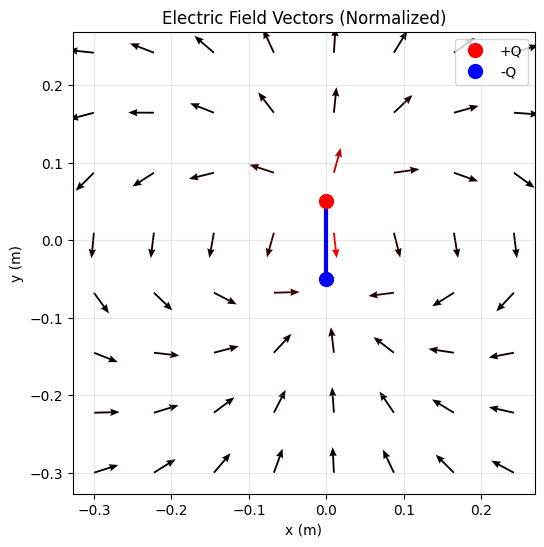

In [4]:
def plot_field_vectors(Ex, Ey, grid_x=grid_x, grid_y=grid_y,
                       x_pos=x_pos, y_pos=y_pos, L=L,
                       skip=4, cmap='hot', title='Electric Field Vectors (Normalized)'):
    """
    Plot normalized electric field vectors (quiver), colored by magnitude.
    Returns (fig, ax).
    """
    E_mag = np.sqrt(Ex**2 + Ey**2)
    Ex_norm = Ex / (E_mag + 1e-10)
    Ey_norm = Ey / (E_mag + 1e-10)

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.quiver(grid_x[::skip, ::skip], grid_y[::skip, ::skip],
              Ex_norm[::skip, ::skip], Ey_norm[::skip, ::skip],
              E_mag[::skip, ::skip],
              cmap=cmap,
              scale=None,
              scale_units='xy',
              angles='xy',
              width=0.004,
              headwidth=4,
              headlength=5)

    ax.plot([x_pos, x_pos], [y_pos - L/2, y_pos + L/2], 'b-', linewidth=3)
    ax.plot(x_pos, y_pos + L/2, 'ro', markersize=10, label='+Q', zorder=10)
    ax.plot(x_pos, y_pos - L/2, 'bo', markersize=10, label='-Q', zorder=10)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    return fig, ax

# Example usage
fig, ax = plot_field_vectors(Ex, Ey)
plt.show()

Now let's generate our dataset generating many points for different combinations of input features L, W, x_pos, y_pos, V, grid_x, grid_y

- L: antenna length (range: 0.01 to 0.2 meters)
- x_pos: x-position of antenna center (range: -0.1 to 0.1 m)
- y_pos: y-position of antenna center (range: -0.1 to 0.1 m)
- V: applied voltage (range: 1 to 100 volts)

In [5]:
# (L, x_pos, y_pos, V)

SEED = 42

l_bounds = [0.01, -0.1, -0.1, 1]
u_bounds = [0.2, 0.1, 0.1, 100]
n_circuits = 100

from scipy.stats import qmc
from sqlalchemy import values
sampler = qmc.LatinHypercube(d=4, seed=SEED)
sample = sampler.random(n=n_circuits)
sample = qmc.scale(sample, l_bounds, u_bounds)

In [6]:
sample.shape

(100, 4)

In [7]:
results = []

for L, x_pos, y_pos, V in sample:
    Ex, Ey = compute_dipole_field(L, x_pos, y_pos, V, grid_x, grid_y)
    results.append((Ex, Ey))
    # Further processing can be done here

#results # Show first two results

In [8]:
results_array = np.array(results)
results_array.shape

(100, 2, 32, 32)

In [9]:
results_array = results_array.transpose(0, 2, 3, 1)
results_array.shape

(100, 32, 32, 2)

In [10]:
results_array = results_array.reshape(-1, 2)
results_array.shape

(102400, 2)

In [11]:
x_grid = grid_x.flatten()
y_grid = grid_y.flatten()

x_grid.shape, y_grid.shape

((1024,), (1024,))

In [12]:
sample_extended = np.repeat(sample, repeats=1024, axis=0)

sample_extended.shape

(102400, 4)

In [13]:
x_grid_extended = np.tile(x_grid, reps=n_circuits).reshape(-1, 1)
y_grid_extended = np.tile(y_grid, reps=n_circuits).reshape(-1, 1)

x_grid_extended.shape, y_grid_extended.shape

((102400, 1), (102400, 1))

In [14]:
inputs = np.concatenate([sample_extended, x_grid_extended, y_grid_extended], axis=1)
target = results_array

inputs.shape, target.shape

((102400, 6), (102400, 2))

In [15]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

input_tensor = torch.tensor(inputs, dtype=torch.float32)
output_tensor = torch.tensor(target, dtype=torch.float32)

input_tensor.shape, output_tensor.shape

(torch.Size([102400, 6]), torch.Size([102400, 2]))

In [16]:
mask = (abs(output_tensor[:, 0]) <= 3e4) & (abs(output_tensor[:, 1]) <= 3e4)

output_tensor_mask = output_tensor[mask]
input_tensor_mask = input_tensor[mask]

input_tensor_mask.shape, output_tensor_mask.shape

(torch.Size([102378, 6]), torch.Size([102378, 2]))

In [17]:
def signed_log(x):
    return torch.sign(x) * torch.log1p(torch.abs(x))

output_tensor_log = signed_log(output_tensor_mask)

output_tensor_log.std(), output_tensor_log.mean()

(tensor(2.0835), tensor(0.0914))

In [18]:
vals = output_tensor_log.flatten()

print(torch.quantile(vals, torch.tensor([0.01, 0.1, 0.5, 0.9, 0.99])))

tensor([-5.6373, -2.4697,  0.0519,  2.6287,  5.4012])


In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    input_tensor_mask, output_tensor_log, test_size=0.15, random_state=42, shuffle=False
)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([87021, 6]),
 torch.Size([87021, 2]),
 torch.Size([15357, 6]),
 torch.Size([15357, 2]))

In [20]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = torch.tensor(X_scaler.fit_transform(X_train), dtype=torch.float32)
y_train_scaled = torch.tensor(y_scaler.fit_transform(y_train), dtype=torch.float32)

X_val_scaled = torch.tensor(X_scaler.transform(X_val), dtype=torch.float32)
y_val_scaled = torch.tensor(y_scaler.transform(y_val), dtype=torch.float32)

X_train_scaled.shape, y_train_scaled.shape, X_val_scaled.shape, y_val_scaled.shape

(torch.Size([87021, 6]),
 torch.Size([87021, 2]),
 torch.Size([15357, 6]),
 torch.Size([15357, 2]))

In [21]:
train_tensor = TensorDataset(X_train_scaled, y_train_scaled)
val_tensor = TensorDataset(X_val_scaled, y_val_scaled)

train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(1360, 240)

In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [23]:
class SurrogateModel(nn.Module):
    def __init__(self,  hidden_dim=256, n_layers=2, input_dim = 6, output_dim = 2):

        super().__init__()

        layers_list = []
        for i in range(n_layers):
            layers_list.append(nn.Linear(hidden_dim, hidden_dim))
            layers_list.append(nn.ReLU())
            
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            *[layer for layer in layers_list],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch.optim as optim
model = SurrogateModel(n_layers=3, hidden_dim=128).to(device)  # best hyperparameters coming from Optuna
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.MSELoss()

num_epochs = 100
physics_loss_weight = 0.0  # Weight for divergence loss

train_losses = []
train_data_losses = []
train_physics_losses = []
val_losses = []
val_data_losses = []
val_physics_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_data_loss = 0.0
    running_physics_loss = 0.0

    for inputs_batch, targets_batch in train_loader:
        inputs_batch = inputs_batch.to(device)
        targets_batch = targets_batch.to(device)

        optimizer.zero_grad()

        outputs_batch = model(inputs_batch)

        data_loss = criterion(outputs_batch, targets_batch) 

        loss = data_loss

        loss.backward()

        optimizer.step()

        # Accumulate losses weighted by batch size
        batch_size = inputs_batch.size(0)
        running_train_loss += loss.item() * batch_size
        running_data_loss += data_loss.item() * batch_size

    n_train = len(train_loader.dataset)

    epoch_train_loss = running_train_loss / n_train
    epoch_data_loss = running_data_loss / n_train

    # Store
    train_losses.append(epoch_train_loss)
    train_data_losses.append(epoch_data_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    running_val_data_loss = 0.0
    running_val_physics_loss = 0.0

    with torch.no_grad():
        for inputs_batch, targets_batch in val_loader:
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)

            outputs_batch = model(inputs_batch)

            data_loss_val = criterion(outputs_batch, targets_batch)

            val_loss = data_loss_val

            # Accumulate
            batch_size = inputs_batch.size(0)
            running_val_loss += val_loss.item() * batch_size
            running_val_data_loss += data_loss_val.item() * batch_size  

    # Average
    n_val = len(val_loader.dataset)
    epoch_val_loss = running_val_loss / n_val
    epoch_val_data = running_val_data_loss / n_val

    # Accumulate
    val_losses.append(epoch_val_loss)
    val_data_losses.append(epoch_val_data)

    # -------- LOGGING --------
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(
            f"Epoch [{epoch+1:3d}/{num_epochs}] | "
            f"Train: {epoch_train_loss:.6f} "
            f"Val: {epoch_val_loss:.6f} "
        )

print("\n✓ Training complete!")

Epoch [  1/100] | Train: 0.167940 Val: 0.094883 
Epoch [ 10/100] | Train: 0.049207 Val: 0.048491 
Epoch [ 20/100] | Train: 0.033826 Val: 0.042589 
Epoch [ 30/100] | Train: 0.032669 Val: 0.050960 
Epoch [ 40/100] | Train: 0.026023 Val: 0.036364 
Epoch [ 50/100] | Train: 0.030076 Val: 0.035304 
Epoch [ 60/100] | Train: 0.024039 Val: 0.026000 
Epoch [ 70/100] | Train: 0.026083 Val: 0.014639 
Epoch [ 80/100] | Train: 0.026528 Val: 0.015990 
Epoch [ 90/100] | Train: 0.023279 Val: 0.044449 
Epoch [100/100] | Train: 0.019733 Val: 0.045585 

✓ Training complete!


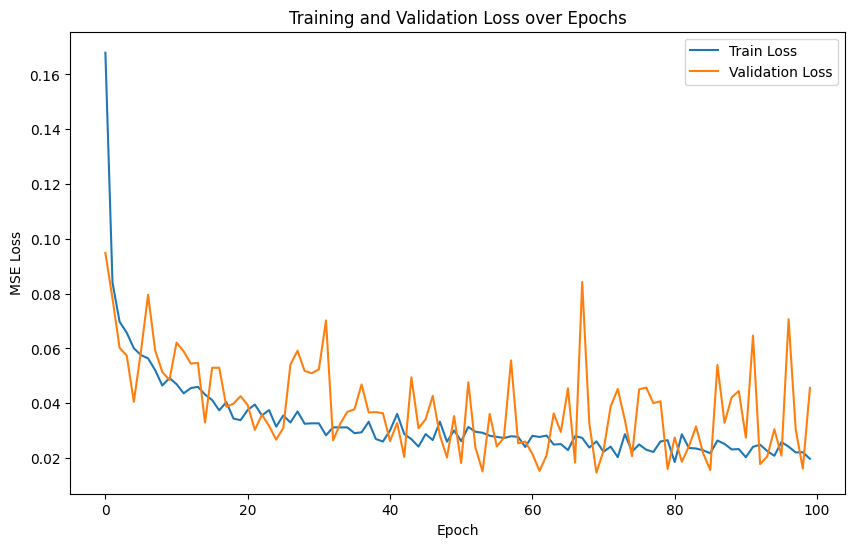

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')

plt.legend()
plt.show()

In [26]:
model.eval()

circuit_idx = 20

def inverse_signed_log(y):
    return torch.sign(y) * torch.expm1(torch.abs(y))

# Let's evaluate performances for one antenna setup
X_test = X_val_scaled[circuit_idx:circuit_idx+1024, :].to(device=device)
y_test = y_val[circuit_idx:circuit_idx+1024, :]
y_test = inverse_signed_log(y_test).cpu().numpy()


with torch.no_grad():
    sample_input = X_test  # Take first sample from validation set
    predicted_output = model(sample_input)
    predicted_output = inverse_signed_log(predicted_output)
    predicted_output = y_scaler.inverse_transform(
        predicted_output.cpu().numpy()
    )

predicted_output.shape, y_test.shape


((1024, 2), (1024, 2))

In [27]:
predicted_output = predicted_output.T
y_test = y_test.T


predicted_output.shape, y_test.shape

((2, 1024), (2, 1024))

In [28]:
predicted_output = predicted_output.reshape(2, 32, 32)
y_test = y_test.reshape(2, 32, 32)

In [29]:
Ex_pred = predicted_output[0]
Ey_pred = predicted_output[1]

Ex_target = y_test[0]
Ey_target = y_test[1]

Ex_pred.shape, Ey_pred.shape, Ex_target.shape, Ey_target.shape

((32, 32), (32, 32), (32, 32), (32, 32))

In [30]:
sample_input_not_scaled = X_scaler.inverse_transform(sample_input.cpu())

sample_input_not_scaled.shape

(1024, 6)

In [31]:
L, x_q, y_q, V, x, y = sample_input_not_scaled.T

L.shape, x_q.shape, y_q.shape, V.shape, x.shape, y.shape

((1024,), (1024,), (1024,), (1024,), (1024,), (1024,))

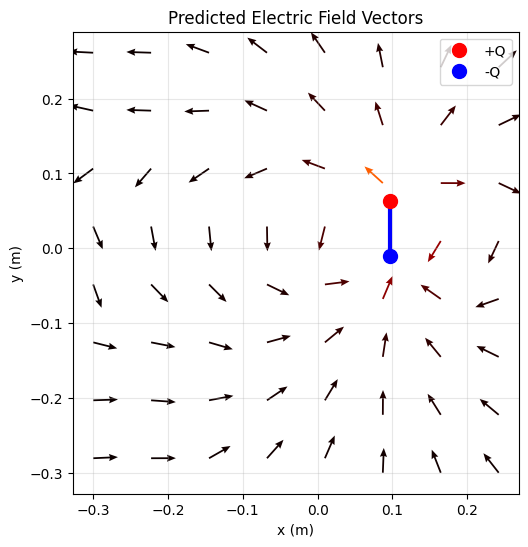

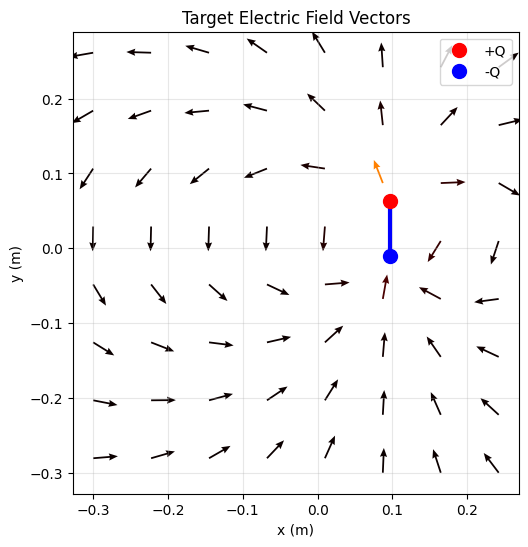

In [32]:
fig, ax = plot_field_vectors(Ex_pred, Ey_pred, x_pos=x_q[0], y_pos=y_q[0], L=L[0], grid_x=x.reshape(32, 32), grid_y=y.reshape(32, 32), title='Predicted Electric Field Vectors')
plt.show()

fig, ax = plot_field_vectors(Ex_target, Ey_target, x_pos=x_q[0], y_pos=y_q[0], L=L[0], grid_x=x.reshape(32, 32), grid_y=y.reshape(32, 32), title='Target Electric Field Vectors')
plt.show()

In [33]:
torch.save(model.state_dict(), '../models/dipole_surrogate_model.pth')
# Saving the scalers
import joblib
joblib.dump(X_scaler, '../models/x_scaler.save')
joblib.dump(y_scaler, '../models/y_scaler.save')



['../models/y_scaler.save']